# GPU Info

In [7]:
!nvidia-smi

Sat Nov 20 20:08:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    40W / 300W |  15239MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [1]:
from main import build_model, normalize_img
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

# Utility Functions

In [3]:
def build_pipelines(num_train_examples, num_test_examples):
    """
    Builds the training and test set
    """
    (ds_train, ds_test), ds_info = tfds.load(
        "mnist",
        split=["train", "test"],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
    )

    ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).take(
        num_train_examples
    )
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(num_train_examples)
    ds_train = ds_train.batch(128)
    ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

    ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).take(
        num_test_examples
    )
    ds_test = ds_test.batch(128)
    ds_test = ds_test.cache()
    ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

    return ds_train, ds_test


In [4]:
def run_experiment(i, num_train_examples=60000, num_test_examples=10000):
    """
    Trains an model on the MNIST dataset given the number of training and test examples
    """
    ds_train, ds_test = build_pipelines(num_train_examples, num_test_examples)
    model = build_model()
    model.fit(ds_train, epochs=6, validation_data=ds_test, verbose=0)
    _, test_accuracy = model.evaluate(ds_test, verbose=0)
    return test_accuracy


# Experiments

## Variable Training Set, Fixed Test Set

2021-11-20 18:28:13.128572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 18:28:13.138323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 18:28:13.139043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 18:28:13.140222: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

CPU times: user 58min 23s, sys: 24min 21s, total: 1h 22min 44s
Wall time: 1h 5min 10s


[Text(0.5, 0, 'Training Set Size'), Text(0, 0.5, 'Test Accuracy')]

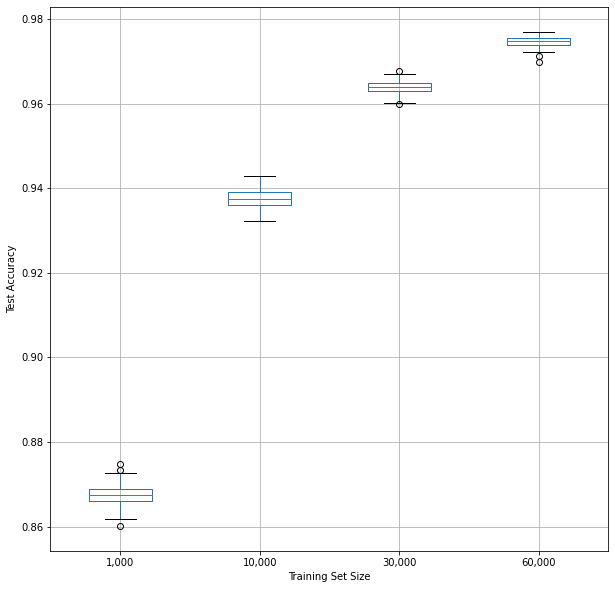

In [5]:
%%time
trials = 100

training_size = [1000, 10000, 30000, 60000]
test_size = 10000

data = [[run_experiment(i, ts, test_size) for i in range(trials)] for ts in training_size]

col_names = [str(f"{i:,}") for i in training_size]
df = pd.DataFrame(data).transpose()
df.columns = col_names

df.boxplot(col_names, figsize=(10,10))\
    .set(xlabel="Training Set Size", ylabel="Test Accuracy")

## Fixed Training Set, Variable Test Set

2021-11-20 20:11:25.150408: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-11-20 20:11:25.944704: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-11-20 20:11:32.548502: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. I

CPU times: user 45min 1s, sys: 18min 34s, total: 1h 3min 35s
Wall time: 52min 17s


[Text(0.5, 0, 'Test Set Size'), Text(0, 0.5, 'Test Accuracy')]

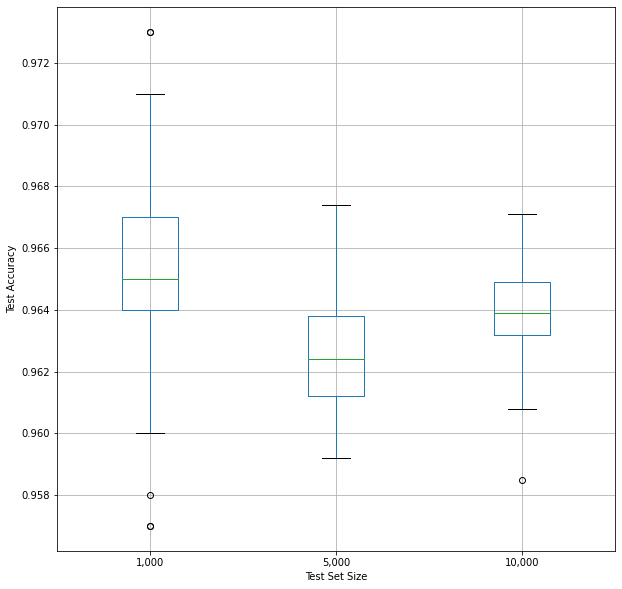

In [8]:
%%time
trials = 100

training_size = 30000
test_size = [1000, 5000, 10000]

data = [[run_experiment(i, training_size, ts) for i in range(trials)] for ts in test_size]

col_names = [str(f"{i:,}") for i in test_size]
df = pd.DataFrame(data).transpose()
df.columns = col_names

df.boxplot(col_names, figsize=(10,10))\
    .set(xlabel="Test Set Size", ylabel="Test Accuracy")